In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import astropy
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import h5py

import wsdb
import psycopg2 as pg2
from casu_lib import VISTA_CONNECTION, query_result_to_dict
from helper_functions import *

In [ ]:
wsdb.connect(username='colin_mao')

In [ ]:
def do_vista_query(query_str):
    conn = VISTA_CONNECTION()
    cur = conn.cursor(cursor_factory=pg2.extras.DictCursor)
    cur.execute(query_str)
    dict_result=query_result_to_dict(cur)
    cur.close()
    conn.close()
    
    return pd.DataFrame(dict_result)

In [ ]:
import warnings
from astropy.io.fits.verify import VerifyWarning
from astropy.wcs import FITSFixedWarning
warnings.simplefilter('ignore', category=VerifyWarning)
warnings.simplefilter('ignore', category=FITSFixedWarning)

**Get VHS samples**

In [ ]:
sample = do_vista_query("""
SELECT * FROM vistaqc
WHERE (ra <= 45 OR ra >= 345) AND dec >= -60 AND dec <= 0 
      AND is_tile = False AND filtname = 'Ks' AND programme_id = 5
""")  # AND chipno = 7

In [ ]:
sample.shape

In [ ]:
sample = sample[sample.filepath.apply(lambda f: f.split('/')[2] != 'apm55_c')]
sample.shape

In [ ]:
sample.loc[sample.ra > 180, 'ra'] = sample[sample.ra > 180].ra - 360

In [ ]:
plt.scatter(sample.ra, sample.dec)

In [ ]:
plt.hist(sample.ra)

In [ ]:
plt.hist(sample.dec)

In [ ]:
sample.ra1.max(), sample.ra2.max(), sample.ra3.max(), sample.ra4.max()

In [ ]:
sample.ra1.min(), sample.ra2.min(), sample.ra3.min(), sample.ra4.min()

In [ ]:
sample.dec1.max(), sample.dec2.max(), sample.dec3.max(), sample.dec4.max()

In [ ]:
sample.dec1.min(), sample.dec2.min(), sample.dec3.min(), sample.dec4.min()

**Testing stuff stored in vistaqc**

In [ ]:
row = sample.iloc[0]

In [ ]:
row.skylevel / row.exptime, row.magzpt

In [ ]:
row.magzpt - 2.5*np.log10(row.skylevel / row.exptime)

In [ ]:
sample.magzpt.mean(), sample.magzpt.std()

In [ ]:
plt.hist(sample.teltemp, bins=32)
plt.show()

**Get Gaia sources**

In [ ]:
all_stars = pd.DataFrame(wsdb.sql2npy("""
    SELECT source_id, ra, dec, k_m
    FROM gaia_dr2_aux.gaia_source_2mass_xm 
    WHERE (ra <= 46 OR ra >= 344) AND dec >= -61 AND dec <= 1
""")).set_index('source_id')  # Note, extra buffer of 1 arcsec
len(all_stars)

In [ ]:
all_stars.loc[all_stars.ra > 180, 'ra'] = all_stars[all_stars.ra > 180].ra - 360

In [ ]:
some_stars = all_stars.sample(2000)
plt.scatter(some_stars.ra, some_stars.dec)

**Calculate intersection of VHS chips with Gaia sources**

In [ ]:
sample['Gaia_stars'] = None
found_a = 0
found_b = 0
for i, row in enumerate(sample.itertuples()):
    if i % 100 == 0:
        print('{}/{}/{}'.format(found_b, found_a, i), end=' ', flush=True)
    
    min_ra, max_ra, min_dec, max_dec = get_corners(row)
    
    stars = filter_dataframe(all_stars, 'ra', min_ra, max_ra)
    stars = filter_dataframe(stars, 'dec', min_dec, max_dec)
    
    if len(stars) > 0:
        found_a += 1  # Soft count (bounding rectangle)
        
        w = make_wcs(row)
        stars['x'], stars['y'] = np.round(w.wcs_world2pix(stars[['ra', 'dec']], 0).T).astype(int)
        
        stars = filter_dataframe(stars, 'x', 0, row.naxis2-1)
        stars = filter_dataframe(stars, 'y', 0, row.naxis1-1)
        
        if len(stars) > 0:
            found_b += 1  # Saturated stars within the image
            sample.at[row.Index, 'Gaia_stars'] = stars

print('{}/{}/{}'.format(found_b, found_a, len(sample)))

In [ ]:
sample.shape

In [ ]:
sample = sample[sample.Gaia_stars.notnull()]
sample.shape

In [ ]:
sum(sample.Gaia_stars.apply(len))

In [ ]:
u = sample.drop('Gaia_stars', axis=1)[sample.exptime == 7.5].nunique()
for n, s in u.groupby(u):
    print(n, '-', end=' ')
    for k in s.index:
        print(k, end=' | ')
    print()

In [ ]:
u = sample.drop('Gaia_stars', axis=1)[sample.exptime == 7.5].nunique()
for n, s in u.groupby(u):
    for k in s.index:
        print(k, end=' | ')

In [ ]:
sample['saturation_norm'] = sample.saturation - sample.skylevel

In [ ]:
plt.hist(sample.saturation, bins=32)
plt.hist(sample.saturation_norm, bins=32, alpha=0.5)
plt.show()

In [ ]:
sample.saturation_norm.min()

In [ ]:
sample.to_pickle('/notebooks/labels/VHS_allchip.pkl')

In [ ]:
sample = pd.read_pickle('/notebooks/labels/VHS_allchip.pkl')

**Save the relevant Gaia sources**

In [ ]:
from collections import Counter
VHS_stars = Counter()
for i, row in enumerate(sample.itertuples()):
    if i % 1000 == 0:
        print(i, end=' ', flush=True)
    VHS_stars.update(row.Gaia_stars.index)

In [ ]:
len(VHS_stars)

In [ ]:
VHS_stars.most_common(10)

In [ ]:
sum(VHS_stars.values())

In [ ]:
sum(np.fromiter(VHS_stars.values(), dtype=np.int32) != 1)

In [ ]:
filtered_stars = all_stars.loc[VHS_stars.keys()]
len(filtered_stars)

In [ ]:
filtered_stars.k_m.max(), filtered_stars.k_m.min()

In [ ]:
filtered_stars.to_pickle('/notebooks/labels/Gaia_filtered_allchip.pkl')

In [224]:
filtered_stars = pd.read_pickle('/notebooks/labels/Gaia_filtered_allchip.pkl')

**Look at sample of stars of different magnitudes**

In [ ]:
row = sample.iloc[0]
with fits.open(os.path.join('./data/VISTA/FITS/', row.filename)) as hdu:        
    data = hdu[row.chipno].data - row.skylevel

In [ ]:
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

In [ ]:
plt.hist(interval(data).flatten())

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9), subplot_kw={'xticks': [], 'yticks': []})

ax.imshow(interval(data), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')

plt.tight_layout()
plt.show()

In [222]:
def get_cutouts(k, num=1, err=1, size=128):
    low = (size - 1) // 2
    high = size - low

    cs = []
    stars_idx = (filtered_stars.k_m - k).abs().argsort()
    for sidx in stars_idx[:128]:
        star = filtered_stars.iloc[sidx]
        
        if np.abs(star.k_m - k) > err:
            return cs
        
        sample_crop = filter_dataframe(sample, 'ra', star.ra-0.5, star.ra+0.5)
        sample_crop = filter_dataframe(sample_crop, 'dec', star.dec-0.5, star.dec+0.5)
        
        for i, row in enumerate(sample_crop.itertuples()):
            if star.name in row.Gaia_stars.index:
                star2 = row.Gaia_stars.loc[star.name].apply(int)
                
                with fits.open(os.path.join('./data/VISTA/FITS/', row.filename)) as hdu:        
                    data = hdu[row.chipno].data
                    cutout = data[(star2.y-low):(star2.y+high), (star2.x-low):(star2.x+high)] - row.skylevel

                if cutout.shape == (size, size):
                    cs.append((star.k_m, cutout))

                if len(cs) >= num:
                    return cs
    
    return cs

In [225]:
cutouts = {}
ks = [-1.0, 0.0] + list(np.arange(1, 14.5, 0.5)) + [15.0, 16.0, 17.5]
for k in ks:
    cutouts[k] = get_cutouts(k, 1, 0.25)
    print('{}:{}'.format(k, len(cutouts[k])), end=' ', flush=True)
sum([len(cs) for cs in cutouts.values()])

-1.0:1 0.0:1 1.0:1 1.5:1 2.0:1 2.5:1 3.0:1 3.5:1 4.0:1 4.5:1 5.0:1 5.5:1 6.0:1 6.5:1 7.0:1 7.5:1 8.0:1 8.5:1 9.0:1 9.5:1 10.0:1 10.5:1 11.0:1 11.5:1 12.0:1 12.5:1 13.0:1 13.5:1 14.0:1 15.0:1 16.0:1 17.5:1 

32

(53366.9679932, 24567.065880166003)

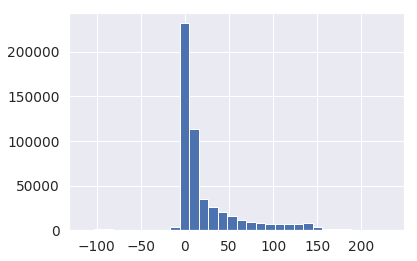

In [226]:
# Calculate normalizing factor for plotting first
i = 0
pixels = []
for k, cs in cutouts.items():
    for km, c in cs:
        if i >= 32:
            break
        pixels.append(c.flatten())        
        i += 1
pixels = np.array(pixels).flatten()
plt.hist(nsqrt(pixels), bins=32)
pixels.max(), np.quantile(pixels, 0.99)

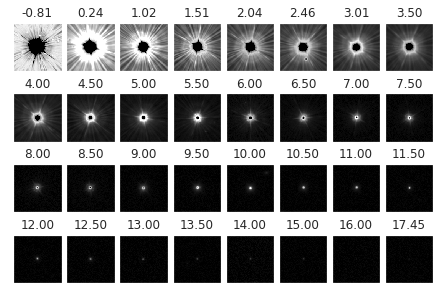

In [248]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(6, 4), subplot_kw={'xticks': [], 'yticks': []})

i = 0
for k, cs in cutouts.items():
    for km, c in cs:
        if i >= 32:
            break
        
        ax = axs.flatten()[i]
        # ax.imshow(np.sqrt(np.clip(c, -32, 20000)+32), vmin=0, vmax=np.sqrt(20000+32), cmap=plt.cm.gray, origin='lower')
        ax.imshow(nsqrt(c), vmin=0, vmax=np.sqrt(25000), cmap=plt.cm.gray, origin='lower')
        ax.set_title('{:.2f}'.format(km), fontsize=12)
        
        i += 1

plt.tight_layout(pad=0, h_pad=-0.5, w_pad=-0.6)
# plt.tight_layout(pad=0, h_pad=-1, w_pad=0)
plt.savefig('./imgs/')
plt.show()

In [ ]:
plt.hist(filtered_stars.k_m, bins=32, log=True)

**File copying**

**Direct FITS copying to local**

In [ ]:
import shutil

copied = 0
not_copied = []
for i, (filename, chips) in enumerate(sample.groupby(sample.filename)):
    if i % 100 == 0:
        print('{:d}/{:d}'.format(copied, i), end=' ', flush=True)

    row = chips.iloc[0]  # filepath and filename should be the same within groupby
    origpath = os.path.join(row.filepath, row.filename)
    savepath = os.path.join('./data/VISTA/FITS/', row.filename)
    if not os.path.exists(savepath):
        not_copied.append([origpath, savepath])
        # shutil.copyfile(origpath, savepath)
        copied += 1

print("Copied:", copied)

**Save as cutouts in HDF5**

In [3]:
size = 64
low = (size - 1) // 2
high = size - low
size, low, high

(64, 31, 33)

In [ ]:
sample = pd.read_pickle('/notebooks/labels/VHS_allchip.pkl')

In [ ]:
ras = np.linspace(-15, 45, 5)
decs = np.linspace(-60, 0, 5)
ras, decs

In [ ]:
for i in range(16):
    ra1, ra2, dec1, dec2 = ras[i//4], ras[i//4+1], decs[i%4], decs[i%4+1]
    sample_crop = filter_dataframe(sample, 'ra', ra1, ra2)
    sample_crop = filter_dataframe(sample_crop, 'dec', dec1, dec2)
    print(i, ra1, ra2, dec1, dec2, len(sample_crop), np.sum(sample.ra == ra1), np.sum(sample.dec == dec1))

In [ ]:
from collections import Counter
Counter(sample['exptime'])

In [ ]:
metadata_cols = ['skylevel', 'skynoise', 'saturation_norm', 'magzpt', 'magzerr', 'seeing', 'ellipticity', 'posang', 'az', 'alt', 'teltemp', 'chipno']

In [ ]:
selected_metadata = pd.DataFrame(columns=['k_m']+metadata_cols)
ix = 0

for n in range(8, 16):
    
    i = 0
    h2 = h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_prenorm_{}.h5'.format(n))
    h2.attrs['metadata_cols'] = np.array(['k_m']+metadata_cols, dtype='S32')
    
    ra1, ra2, dec1, dec2 = ras[n//4], ras[n//4+1], decs[n%4], decs[n%4+1]
    sample_crop = filter_dataframe(sample, 'ra', ra1, ra2)
    sample_crop = filter_dataframe(sample_crop, 'dec', dec1, dec2)
    
    print(n, (int(ra1), int(ra2)), (int(dec1), int(dec2)), len(sample_crop), end=': ', flush=True)
    
    ixn = 0
    for filename, chips in sample_crop.groupby(sample_crop.filename):
        h1 = fits.open(os.path.join('./data/VISTA/FITS/', filename))
        
        for row in chips.itertuples():
            if i % 200 == 0:
                print('{}/{}/{}'.format(ixn, i, ix), end=' ', flush=True)
            i += 1

            if row.exptime != 7.5:
                continue
            
            sat_stars = filter_dataframe(row.Gaia_stars, 'k_m', 4, 10)  # Consider stars in magnitude range (4, 10) to be saturated
            for sat_star in sat_stars.itertuples():

                if str(ix) in h2:
                    if h2[str(ix)].attrs['center_id'] == sat_star.Index:
                        ix += 1
                        ixn += 1
                        continue
                    # del h2[str(ix)]
                
                low_x = sat_star.x - low
                low_y = sat_star.y - low
                
                try:
                    cutout = h1[row.chipno].data[(low_y):(low_y+size), (low_x):(low_x+size)] - row.skylevel
                except:
                    print(row)
                    raise
                if cutout.shape != (size, size):
                    continue

                stars = row.Gaia_stars
                stars['x_adj'] = stars.x - low_x
                stars['y_adj'] = stars.y - low_y
                stars = filter_dataframe(stars, 'x_adj', 0, size-1)
                stars = filter_dataframe(stars, 'y_adj', 0, size-1)
                stars = stars.drop(['ra', 'dec', 'x', 'y'], axis=1)
                if np.any(stars.k_m < 4):  # Skip cutouts with extremely saturated stars
                    continue
                if np.sum(stars.k_m < 10) > 1:  # Skip cutouts with more than 1 saturated star
                    continue

                if str(ix) in h2:
                    ix += 1
                    ixn += 1
                    continue
                    # del h2[str(ix)]
                hg = h2.create_group(str(ix))

                hg.create_dataset('data', data=cutout, dtype='f4')
                hg.attrs['stars'] = stars.to_numpy()

                hg.attrs['filename'] = row.filename
                hg.attrs['chipno'] = row.chipno
                hg.attrs['center_id'] = sat_star.Index

                selected_metadata.loc[ix, 'k_m'] = sat_star.k_m
                selected_metadata.loc[ix, metadata_cols] = sample.loc[row.Index, metadata_cols]
                
                hg.attrs['metadata'] = selected_metadata.loc[int(ix)].astype(np.float32)

                ix += 1
                ixn += 1
        
        h1.close()

    h2.close()

    print('{}/{}/{}'.format(ixn, i, ix), flush=True)

In [ ]:
with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_prenorm_0.h5') as h5f:
    print(h5f.attrs['metadata_cols'])
    for f in h5f:
        print(h5f[f].attrs['metadata'])
        break

In [ ]:
print(metadata_cols)

In [ ]:
# Concatenate into one file

selected_metadata = pd.DataFrame(columns=['k_m']+metadata_cols)

h2 = h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_prenorm.h5')
h2.attrs['metadata_cols'] = np.array(['k_m']+metadata_cols, dtype='S32')

ix = 0
for n in range(16):
    with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_prenorm_{}.h5'.format(n)) as h1:
        for ix2 in h1:
            if ix % 1000 == 0:
                print(ix, end=' ', flush=True)
            
            hg = h2.create_group(str(ix))
            
            hg.attrs['stars'] = h1[ix2].attrs['stars']
            hg.attrs['filename'] = h1[ix2].attrs['filename']
            hg.attrs['chipno'] = h1[ix2].attrs['chipno']
            hg.attrs['center_id'] = h1[ix2].attrs['center_id']
            hg.attrs['metadata'] = h1[ix2].attrs['metadata']
            selected_metadata.loc[int(ix)] = h1[ix2].attrs['metadata']
            
            hg.create_dataset('data', data=h1[ix2]['data'], dtype='f4')

            ix += 1
            
h2.close()

In [ ]:
# Read metadata from file

selected_metadata = pd.DataFrame(columns=['k_m']+metadata_cols)

with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_prenorm.h5') as h1:
    for i, ix in enumerate(h1):
        if i % 5000 == 0:
            print(i, end=' ', flush=True)
        selected_metadata.loc[int(ix)] = h1[ix].attrs['metadata']

In [ ]:
selected_metadata.saturation_norm.max()

In [ ]:
selected_metadata.saturation_norm.quantile(1-d)

In [ ]:
plt.hist(selected_metadata.saturation_norm[selected_metadata.saturation_norm >= selected_metadata.saturation_norm.quantile(1-d)], bins=16)

In [ ]:
d = 0.015
metadata_mins = selected_metadata.quantile(d)
metadata_maxs = selected_metadata.quantile(1-d)
metadata_mins.k_m = selected_metadata.k_m.min()
metadata_maxs.k_m = selected_metadata.k_m.max()
metadata_mins.chipno = 1
metadata_maxs.chipno = 16
norm_metadata = ((selected_metadata - metadata_mins) / (metadata_maxs - metadata_mins)) * 2 - 1
norm_metadata = norm_metadata.clip(-1, 1)
norm_metadata.head()

In [ ]:
# selected_metadata.clip(selected_metadata.quantile(d), selected_metadata.quantile(1-d), axis=1).hist(bins=32, figsize=(12, 12))
selected_metadata.saturation_norm.hist(bins=32, figsize=(12, 12))
plt.show()

In [ ]:
# selected_metadata.clip(selected_metadata.quantile(d), selected_metadata.quantile(1-d), axis=1).hist(bins=32, figsize=(12, 12))
norm_metadata.hist(bins=32, figsize=(12, 12))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 12))
norm_metadata.iloc[train_idx].hist(bins=32, ax=ax1)
plt.title('train')
plt.show()

fig, ax2 = plt.subplots(1, 1, figsize=(16, 12))
norm_metadata.iloc[test_idx].hist(bins=32, ax=ax2)
plt.title('test')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.pcolormesh(norm_metadata.cov(), cmap='bwr', vmin=-.5, vmax=.5)
ax.set_aspect('equal')
plt.colorbar()

In [192]:
class BetterPairGrid(sns.PairGrid):
    def __init__(self, data, rot_x=0, rot_y=90, **kwargs):
        super().__init__(data, **kwargs)
    
    def set(self, **kwargs):
        """Set attributes on each subplot Axes, ignoring None."""
        for ax in self.axes.flat:
            if ax is not None:
                ax.set(**kwargs)
        return self

    def _add_axis_labels(self):
        """Add labels to the left and bottom Axes."""
        for ax, label in zip(self.axes[-1, :], self.x_vars):
            ax.set_xlabel(label, rotation=60)
        for ax, label in zip(self.axes[:, 0], self.y_vars):
            ax.set_ylabel(label, rotation=30, ha='right')
        if self._corner:
            self.axes[0, 0].set_ylabel("")
    
    def _plot_bivariate(self, x_var, y_var, ax, func, kw_color, **kwargs):
        """Draw a bivariate plot on the specified axes."""
        plt.sca(ax)
        if x_var == y_var:
            axes_vars = [x_var]
        else:
            axes_vars = [x_var, y_var]
        hue_grouped = self.data.groupby(self.hue_vals)
        for k, label_k in enumerate(self.hue_names):

            # Attempt to get data for this level, allowing for empty
            try:
                data_k = hue_grouped.get_group(label_k)
            except KeyError:
                data_k = pd.DataFrame(columns=axes_vars,
                                      dtype=np.float)

            if self._dropna:
                data_k = data_k[axes_vars].dropna()

            x = data_k[x_var]
            y = data_k[y_var]

            for kw, val_list in self.hue_kws.items():
                kwargs[kw] = val_list[k]
            color = self.palette[k] if kw_color is None else kw_color

            func(x, y, label=label_k, **kwargs)

        self._clean_axis(ax)
        self._update_legend_data(ax)

In [201]:
data = norm_metadata.rename(columns={'saturation_norm': 'saturation'})  # [['k_m', 'skylevel', 'skynoise', 'saturation']].head(10000)
data.shape

(86502, 13)

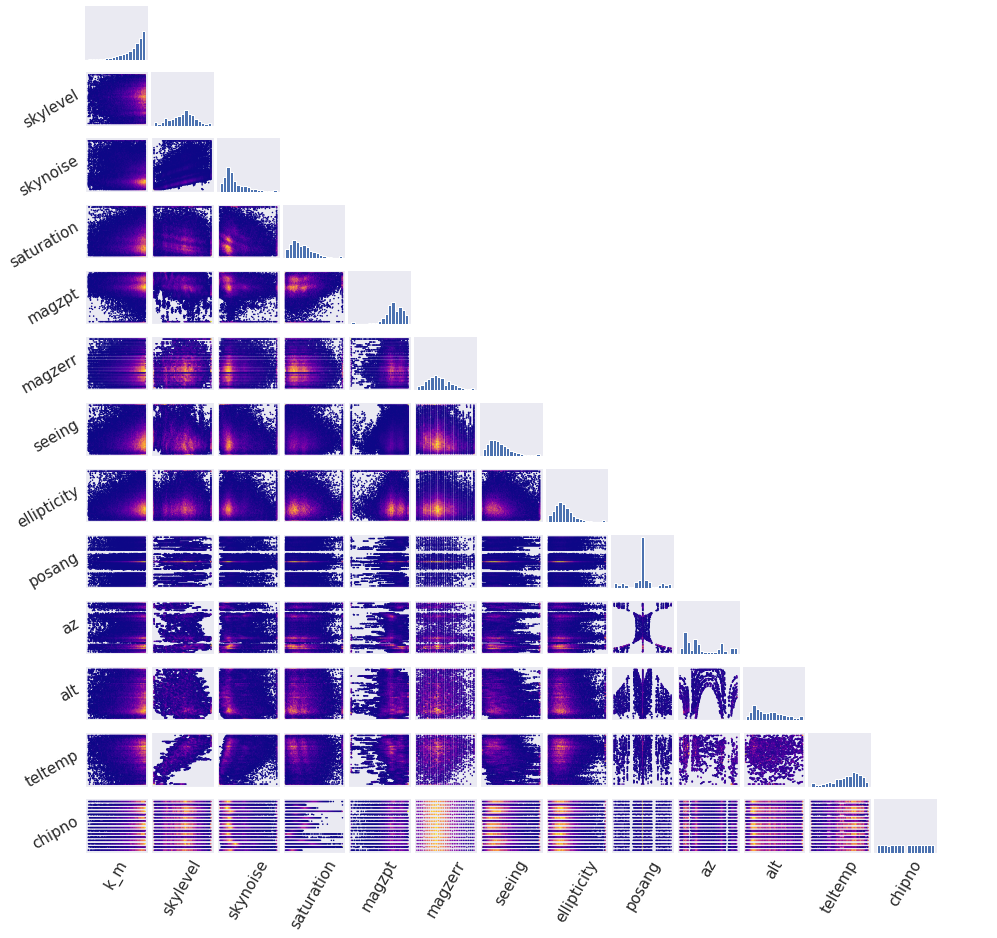

In [203]:
sns.set(font_scale=1.25)
g = BetterPairGrid(data, layout_pad=-0.6, corner=True, height=1., aspect=1)

g.map_diag(plt.hist, bins=17)
# g.map_lower(sns.scatterplot, marker='+', size=0.1, alpha=0.01)
g.map_lower(plt.hexbin, mincnt=1, cmap=plt.cm.plasma)

g.set(xticks=[], yticks=[])
# g.axes = g.axes[::-1]

g.fig.show()
g.savefig('./imgs/metadata_correlation_13.png', dpi=300, transparent=True)

In [ ]:
norm_metadata.to_pickle('/notebooks/labels/HDF5_F4_s64_k4-10_unique_norm6.pkl')

In [91]:
norm_metadata = pd.read_pickle('/notebooks/labels/HDF5_F4_s64_k4-10_unique_norm6.pkl')

In [ ]:
from collections import Counter
Counter(sample.njitter), Counter(sample.jitterx), Counter(sample.jittery), Counter(sample.jittery + sample.jittery)

In [ ]:
def get_color(row):
    if row.jitterx == 0:
        if row.jittery == 0:
            return 'r'
        else:
            return 'b'
    else:
        if row.jittery == 0:
            return 'g'
        else:
            return 'y'

In [ ]:
plt.scatter(sample.skylevel, sample.skynoise, marker='+', alpha=0.5, c=sample.apply(get_color, axis=1))

In [ ]:
from collections import defaultdict

pixels = defaultdict(list)
with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_prenorm.h5') as h5f:
    print(len(h5f), len(h5f)*64*64)
    for i, ix in enumerate(h5f):
        if i % 5000 == 0:
            print(i, end=' ', flush=True)
        data = np.array(h5f[ix]['data']).flatten()  # / h5f[ix].attrs['metadata'][3]
        pixels[h5f[ix].attrs['chipno']].append(data)
pixels = {k: np.array(v).flatten() for k, v in pixels.items()}

In [ ]:
np.sum([np.prod(p.shape) for p in pixels.values()])

In [ ]:
sns.set(font_scale=1)

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(16, 12))

for i, ax in enumerate(axs.flatten()):
    ax.hist(pixels[i+1].flatten(), bins=32, log=True)

plt.show()

In [ ]:
for i in range(16):
    plt.hist(pixels[i+1].flatten(), bins=32, log=True, label=str(i+1), alpha=0.3)

plt.legend()
plt.show()

In [ ]:
all_pixels = np.concatenate(list(pixels.values()))
len(all_pixels)

In [ ]:
plt.hist(np.clip(all_pixels.flatten(), -100000, 80000), bins=32, log=True)
plt.show()

In [ ]:
np.sum(all_pixels - np.clip(all_pixels, -100000, 80000))

In [ ]:
sorted_all_pixels = np.sort(all_pixels)

In [ ]:
plt.plot(sorted_all_pixels[-100000:][::-1])

In [ ]:
min_sat_norm, max_sat_norm = all_pixels.min(), all_pixels.max()
min_sat_norm, max_sat_norm

In [220]:
from collections import defaultdict
inside = defaultdict(list)
outside = defaultdict(list)

with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_prenorm.h5') as h5f:
    for i, ix in enumerate(h5f):
        if i % 5000 == 0:
            print(i, end=' ', flush=True)

        data = h5f[ix]['data']
        for n in range(11):
            idx = np.array(np.nonzero(data < -n*h5f[ix].attrs['metadata'][2]))
            inside[n].append(np.sum(np.logical_and(idx >= (32-16), idx <= (32+16)).all(axis=0)))
            outside[n].append(np.sum(np.logical_or(idx < (32-16), idx > (32+16)).any(axis=0)))

inside = pd.DataFrame(inside)
outside = pd.DataFrame(outside)

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(inside.mean(), label='inside mean', c='r')
plt.plot(inside.std(), label='inside std', c='r', ls='--')
plt.plot(outside.mean(), label='outside mean', c='b')
plt.plot(outside.std(), label='outside std', c='b', ls='--')
plt.xlabel('n (* skynoise)')
plt.ylabel('mean count')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import shutil
origpath = '/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_prenorm.h5'
savepath = '/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6.h5'

if os.path.exists(savepath):
    os.remove(savepath)
shutil.copyfile(origpath, savepath)

h2 = h5py.File(savepath)

h2.attrs['metadata_cols'] = np.array(['k_m']+metadata_cols, dtype='S32')
h2.attrs['metadata_mins'] = metadata_mins
h2.attrs['metadata_maxs'] = metadata_maxs

max_pix = 80000

i = 0
for i, ix in enumerate(h2):
    if i % 5000 == 0:
        print(i, end=' ', flush=True)
    
    skynoise = h2[ix].attrs['metadata'][2]
    sat_norm = h2[ix].attrs['metadata'][3]
    cutout = np.array(h2[ix]['data'])
    cutout = np.where(cutout < -6*skynoise, -max_pix, cutout)
    cutout = np.clip(cutout / max_pix, -1, 1)
    
    del h2[ix]['data']
    h2[ix].create_dataset('data', data=cutout, dtype='f4')
    
    h2[ix].attrs['metadata'] = norm_metadata.loc[int(ix)].to_numpy()

h2.close()

In [ ]:
with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6.h5') as h5f:
    print(h5f.attrs['metadata_cols'])
    print(h5f.attrs['metadata_mins'])
    print(h5f.attrs['metadata_maxs'])
    for f in h5f:
        print(h5f[f].attrs['metadata'])
        print(h5f[f].attrs['metadata'].dtype)
        break

In [ ]:
with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6.h5') as h5f:
    print(len(h5f))

In [215]:
all_pixels = []
with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_prenorm.h5') as h5f:
    print(len(h5f), len(h5f)*64*64)
    for i, ix in enumerate(h5f):
        if i % 5000 == 0:
            print(i, end=' ', flush=True)
        data = np.array(h5f[ix]['data']).flatten() #- h5f[ix].attrs['metadata'][1]
        all_pixels.append(data)
all_pixels = np.array(all_pixels)
all_pixels.shape, np.prod(all_pixels.shape)

86502 354312192
0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 

((86502, 4096), 354312192)

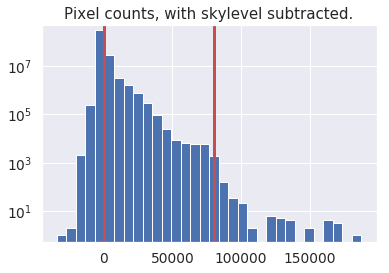

In [218]:
plt.figure(figsize=(6, 4))
plt.hist(all_pixels.flatten(), bins=32, log=True)
plt.plot([0, 0], [0.5, 5e8], lw=3, c='r')
plt.plot([80000, 80000], [0.5, 5e8], lw=3, c='r')
plt.ylim([0.5, 5e8])
plt.title('Pixel counts, with skylevel subtracted.')
plt.savefig('./imgs/pixel_counts.eps')
plt.show()

In [217]:
np.sum(all_pixels > 80000), len(all_pixels.flatten())

(861, 354312192)

In [ ]:
norm_pixels = []
with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6.h5') as h5f:
    print(len(h5f), len(h5f)*64*64)
    for i, ix in enumerate(h5f):
        if i % 5000 == 0:
            print(i, end=' ', flush=True)
        data = np.array(h5f[ix]['data']).flatten()
        norm_pixels.append(data)
norm_pixels = np.array(norm_pixels)
norm_pixels.shape, np.prod(norm_pixels.shape)

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(norm_pixels.flatten(), bins=32, log=True)
plt.title('Post-normalization')
plt.show()

**Saturation 6*skynoise test**

In [ ]:
N, M = 16, 8
max_pix = 25000

In [ ]:
cutouts = []
with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s128_c7_k4-10_unique_norm6.h5') as h5f:
    i = 0
    for k in h5f:
        if i >= N*M:
            break
        cutouts.append(np.array(h5f[k]['data']).astype(np.float32))
        i += 1
cutouts = np.array(cutouts)

In [ ]:
fig, axs = plt.subplots(ncols=N, nrows=M, figsize=(N, M), subplot_kw={'xticks': [], 'yticks': []})

i = 0
for cutout in cutouts:
    ax = axs.flatten()[i]
    ax.imshow(cutout, vmin=-1, vmax=1, cmap=plt.cm.gray, origin='lower')
    i += 1

plt.tight_layout(pad=-1)
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=N, nrows=M, figsize=(N, M), subplot_kw={'xticks': [], 'yticks': []})

i = 0
for cutout in cutouts:
    ax = axs.flatten()[i]
    ax.imshow(cutout[(64-8):(64+8), (64-8):(64+8)], vmin=-1, vmax=1, cmap=plt.cm.gray, origin='lower')
    i += 1

plt.tight_layout(pad=-1)
plt.show()

In [ ]:
from scipy import stats

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

for ax, col in zip(axs.flatten(), norm_metadata.columns):
    kernel = stats.gaussian_kde(norm_metadata[col])
    ax.hist(norm_metadata[col], bins=17, density=True)
    ax.hist(kernel.resample(64)[0], bins=17, density=True)
    ax.plot(np.linspace(-1, 1, 64), kernel(np.linspace(-1, 1, 64)))

**train test split**

In [ ]:
train_idx, test_idx = np.split(np.random.permutation(selected_metadata.index), [80000])

In [ ]:
np.save('./labels/train_idx.npy', train_idx)
np.save('./labels/test_idx.npy', test_idx)

In [ ]:
origpath = '/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6.h5'

savepath = '/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6_train.h5'
data_idx = train_idx

if os.path.exists(savepath):
    os.remove(savepath)

h1 = h5py.File(origpath, 'r')
h2 = h5py.File(savepath)

h2.attrs['metadata_cols'] = np.array(['k_m']+metadata_cols, dtype='S32')
h2.attrs['metadata_mins'] = metadata_mins
h2.attrs['metadata_maxs'] = metadata_maxs

for i, ix in enumerate(data_idx):
    if i % 5000 == 0:
        print(i, end=' ', flush=True)
    
    hg = h2.create_group(str(i))

    ix2 = str(ix)
    hg.attrs['stars'] = h1[ix2].attrs['stars']
    hg.attrs['filename'] = h1[ix2].attrs['filename']
    hg.attrs['chipno'] = h1[ix2].attrs['chipno']
    hg.attrs['center_id'] = h1[ix2].attrs['center_id']
    hg.attrs['metadata'] = h1[ix2].attrs['metadata']

    hg.create_dataset('data', data=h1[ix2]['data'], dtype='f4')

h1.close()
h2.close()

In [ ]:
origpath = '/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6.h5'

savepath = '/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6_test.h5'
data_idx = test_idx

if os.path.exists(savepath):
    os.remove(savepath)

h1 = h5py.File(origpath, 'r')
h2 = h5py.File(savepath)

h2.attrs['metadata_cols'] = np.array(['k_m']+metadata_cols, dtype='S32')
h2.attrs['metadata_mins'] = metadata_mins
h2.attrs['metadata_maxs'] = metadata_maxs

for i, ix in enumerate(data_idx):
    if i % 5000 == 0:
        print(i, end=' ', flush=True)
    
    hg = h2.create_group(str(i))

    ix2 = str(ix)
    hg.attrs['stars'] = h1[ix2].attrs['stars']
    hg.attrs['filename'] = h1[ix2].attrs['filename']
    hg.attrs['chipno'] = h1[ix2].attrs['chipno']
    hg.attrs['center_id'] = h1[ix2].attrs['center_id']
    hg.attrs['metadata'] = h1[ix2].attrs['metadata']

    hg.create_dataset('data', data=h1[ix2]['data'], dtype='f4')

h1.close()
h2.close()

In [ ]:
with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6_train.h5') as h5f:
    print(len(h5f))
with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6_test.h5') as h5f:
    print(len(h5f))

In [221]:
sample.shape

(128295, 239)

**Saturated PSF**

In [2]:
sample = pd.read_pickle('/notebooks/labels/VHS_allchip.pkl')

In [87]:
very_saturated = None
some_saturated = None
unsaturated = None
k_ms = [0, 0, 0]
i = 0

def get_cutout(filename, x, y):
    low_x = star.x - low
    low_y = star.y - low
    with fits.open(os.path.join('./data/VISTA/FITS/', row.filename)) as h1:
        data = h1[row.chipno].data
        return data[(low_y):(low_y+size), (low_x):(low_x+size)] #- row.skylevel

for row in sample.sample(frac=1).itertuples():
    if row.exptime != 7.5:
        continue
    if row.saturation < 24000 or row.saturation > 27000:
        continue
    if very_saturated is not None and some_saturated is not None and unsaturated is not None:
        break
    
    for star in row.Gaia_stars.itertuples():
        if i % 100 == 0:
            print(i, end=' ', flush=True)
        if very_saturated is not None and some_saturated is not None and unsaturated is not None:
            break
        
        if very_saturated is None and star.k_m > 7.2 and star.k_m < 7.7:
            cutout = get_cutout(row.filename, star.x, star.y)
            if cutout.shape != (64, 64):
                continue
            very_saturated = cutout
            k_ms[0] = star.k_m
            print('found v.sat', end=' ', flush=True)
        if some_saturated is None and star.k_m > 9 and star.k_m < 9.5:
            cutout = get_cutout(row.filename, star.x, star.y)
            if cutout.shape != (64, 64):
                continue
            some_saturated = cutout
            k_ms[1] = star.k_m
            print('found s.sat', end=' ', flush=True)
        if unsaturated is None and star.k_m > 11.5 and star.k_m < 11.7:
            cutout = get_cutout(row.filename, star.x, star.y)
            if cutout.shape != (64, 64):
                continue
            unsaturated = cutout
            k_ms[2] = star.k_m
            print('found unsat', end=' ', flush=True)
        i += 1
print('Done.')

0 found unsat 100 200 300 found s.sat 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 found v.sat Done.


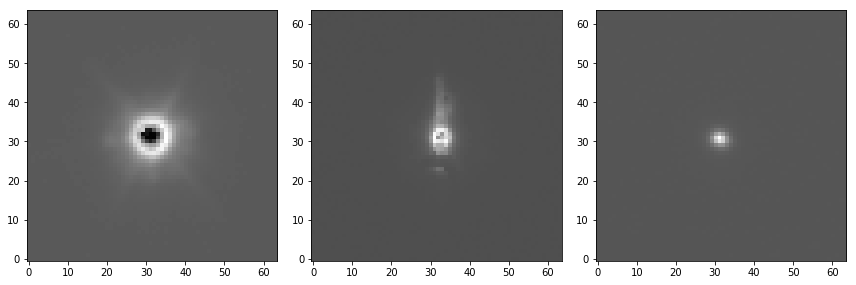

In [88]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 5))
axs[0].imshow(very_saturated, vmin=0, cmap=plt.cm.gray, origin='lower')
axs[1].imshow(some_saturated, vmin=0, cmap=plt.cm.gray, origin='lower')
axs[2].imshow(unsaturated, vmin=0, cmap=plt.cm.gray, origin='lower')

plt.tight_layout()
plt.show()

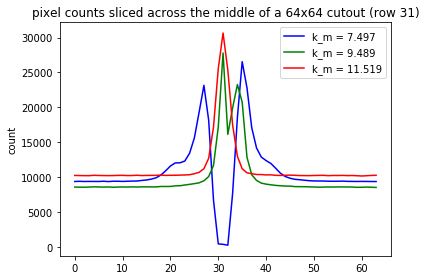

In [90]:
plt.figure(figsize=(6, 4))
plt.plot(very_saturated[31], c='b', label='k_m = {:.3f}'.format(k_ms[0]))
plt.plot(some_saturated[31], c='g', label='k_m = {:.3f}'.format(k_ms[1]))
plt.plot(unsaturated[31], c='r', label='k_m = {:.3f}'.format(k_ms[2]))
plt.title('pixel counts sliced across the middle of a 64x64 cutout (row 31)')
plt.ylabel('count')
plt.legend()
plt.tight_layout()
plt.savefig('./imgs/psf.eps')
plt.show()

**Rotation testing**

In [ ]:
N, M = 4, 4

In [ ]:
cutouts1 = []
cutouts2 = []
cutouts3 = []
with h5py.File('/notebooks/data/VISTA_cutouts/HDF5_F4_s128_c7_k4-10_unique_norm6.h5') as h5f:
    i = 0
    for k in h5f:
        if np.random.rand() > 0.5:
            continue # Drop random samples
        if i >= N*M:
            break
        
        cutout1 = np.array(h5f[k]['data']).astype(np.float32)
        cutout2 = Image.fromarray(cutout1)
        cutout3 = cutout2.rotate(-selected_metadata.loc[int(k)].posang, resample=Image.BILINEAR)
        cutout2 = cutout2.rotate(selected_metadata.loc[int(k)].posang, resample=Image.BILINEAR)
        cutouts1.append(cutout1[32:96, 32:96])
        cutouts2.append(np.array(cutout2)[32:96, 32:96])
        cutouts3.append(np.array(cutout3)[32:96, 32:96])
        i += 1
cutouts1 = np.array(cutouts1)
cutouts2 = np.array(cutouts2)
cutouts3 = np.array(cutouts3)
cutouts1.shape

In [ ]:
fig, axs = plt.subplots(ncols=N, nrows=M, figsize=(2*N, 2*M), subplot_kw={'xticks': [], 'yticks': []})

i = 0
for cutout in cutouts2:
    ax = axs.flatten()[i]
    ax.imshow(nsqrt(cutout), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')
    i += 1

plt.tight_layout(pad=-1)
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=N*3, nrows=M, figsize=(2*N*3, 2*M), subplot_kw={'xticks': [], 'yticks': []})

i = 0
for cutout1, cutout2, cutout3 in zip(cutouts1, cutouts2, cutouts3):
    ax1 = axs.flatten()[3*i]
    ax2 = axs.flatten()[3*i+1]
    ax3 = axs.flatten()[3*i+2]
    ax1.imshow(nsqrt(cutout1), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')
    ax2.imshow(nsqrt(cutout2), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')
    ax3.imshow(nsqrt(cutout3), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')
    i += 1

plt.tight_layout(pad=-1)
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(2*N*3, 2*M), subplot_kw={'xticks': [], 'yticks': []})

axs[0].imshow(nsqrt(cutouts1.mean(axis=0)), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')
axs[1].imshow(nsqrt(cutouts2.mean(axis=0)), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')
axs[2].imshow(nsqrt(cutouts3.mean(axis=0)), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')

plt.tight_layout(pad=-1)
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(2*N*3, 2*M), subplot_kw={'xticks': [], 'yticks': []})

axs[0].imshow(nsqrt(cutouts1.std(axis=0)), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')
axs[1].imshow(nsqrt(cutouts2.std(axis=0)), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')
axs[2].imshow(nsqrt(cutouts3.std(axis=0)), vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')

plt.tight_layout(pad=-1)
plt.show()

In [ ]:
cutouts1.mean(axis=0).shape

In [ ]:
stats.mode(cutouts1, axis=0).mode.shape

In [ ]:
selected_metadata.posang.hist()